In [1]:
# Identification of flow through hovmoller diagram.
#* assumes a small region of interest such that there
#  are a small number of events crossing at any given
#  time and that the motion in the region is similar

#Skye Leake
#Last updated March 24 2023

#OpenCV_sandbox env.

In [2]:
from datetime import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import dates as mpl_dates, collections  as mc
import matplotlib.gridspec as gridspec
from metpy.plots import ctables

from skimage.morphology import skeletonize, medial_axis, closing
from skimage.transform import probabilistic_hough_line
from skimage.draw import line as get_line_pixels

from scipy.ndimage.filters import gaussian_filter
import cv2 as cv

%matplotlib inline

In [3]:
#These data are lon averaged Hovmoller of NEXRAD L2 reflectivity (time increasing on Y axis)
#  for a given region of interest. 
#  data were processed via AWS Batch, results pickled
#  Date, duration and centroids of regions of interest are noted in filename,
#  as are scale factor from a base 1degree square region and any thinning 


objects = []
#path = "./test_data/KLNX_2201607150400_1200_42.000_-102.320_0.000_1.0_1.p" # regular speed storm motion west to east
#path = "./test_data/KUDX_2017061100445_0800_44.000_-102.360_0.500_1.0_2.p" #minimum data example
#path = "./test_data/KMPX_201706110900_1200_45.554_-93.124_0.0_2.0_1.p" # minimum data example, unlikely to work with current settings
path = "./test_data/KBIS_202106080000_1200_46.267_-99.685_0.000_2.0_1.p" # quasistationary/backbuilding
#path = "./test_data/KBIS_202106080000_2400_46.267_-99.865_0.000_1.0_1.p" # quasistationary/backbuilding
#path = "./test_data/KMPX_201706100000_4800_45.554_-93.124_0.000_1.0_1.p" # fast motion over 48hrs, west to east

with (open(path, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break


In [4]:
obj = objects[0]
obj = obj.transpose(2, 1, 0)	#transpose our 3d array for more logical slicing

xlocs = obj[:][:][0].astype(float)
print(f'xlocs shape: {np.shape(xlocs)}')
#print(xlocs[0][0])

strtimes = obj[:][:][1]
#c = converter.DatetimeConverter()
#print(type(c.convert(df['Date'].values, None, None)))

dataDatetimes = mpl_dates.date2num([datetime.strptime(t,'%Y-%m-%dT%H:%M:%SZ') for t in strtimes.ravel()])
dataDatetimes = np.reshape(dataDatetimes, np.shape(strtimes))
print(f'datetime shape: {np.shape(dataDatetimes)}')
#print(dataDatetimes)
#print(type(dataDatetimes[0][0]))

data  = obj[:][:][2].astype(float)
print(f'data shape: {np.shape(data)}')
#print(data[np.shape(data)[0]//2:])						# There are a lot of nans near edges, so print may not be super insightful, so we index to grab a chunk out of the middle
#print(type(data[0][0]))
#todo: assert that all arrays are the same shape

xlocs shape: (800, 117)
datetime shape: (800, 117)
data shape: (800, 117)


In [5]:
# once we have our data loaded we can do basic thresholding 

In [6]:
# convert our data to a binary mask
# this thresh could be found by examining the data first, then setting it dynamically
thresh = 30.0
#bounds=(20.0, 30.0)
#idx= (data>bounds[0])*(data<bounds[1])
#data_mask= np.uint8(np.where(idx , 0, 255))
data_mask = np.uint8(np.where(data>=thresh, 1, 0))

In [7]:
# with data thresholded and any other operators we want to apply we reduce 
#  to the median axis (skeltonize), weight the centers of longer segments,
#  perform a closing to help line detection, and run (probalistic) hough lines

In [8]:
#skel = skeletonize(data_morph)

# Compute the medial axis (skeleton) and the distance transform
#skel, distance = medial_axis(data_morph, return_distance=True)
skel, distance = medial_axis(data_mask, return_distance=True)
# Distance to the background for pixels of the skeleton
dist_on_skel = np.where(distance > 3, distance, 0) * closing(skel)        #we can then filter with distance to remove extranious lines form the skeletinization, leaving major axes

lines = probabilistic_hough_line(dist_on_skel, threshold=10, line_gap=20)
print(lines)

[((116, 486), (116, 400)), ((24, 505), (12, 404)), ((67, 506), (115, 431)), ((89, 530), (76, 470)), ((86, 521), (65, 458)), ((72, 516), (67, 457)), ((78, 503), (108, 450)), ((70, 518), (111, 465)), ((75, 519), (96, 462)), ((19, 466), (13, 405)), ((76, 525), (96, 449)), ((67, 507), (104, 450)), ((18, 464), (14, 404)), ((75, 522), (107, 454)), ((73, 515), (115, 455)), ((73, 516), (110, 465)), ((84, 514), (68, 459)), ((98, 504), (86, 451)), ((72, 511), (66, 459)), ((76, 502), (97, 450)), ((77, 527), (111, 455)), ((64, 483), (115, 478)), ((83, 524), (78, 474)), ((71, 516), (98, 451)), ((81, 517), (64, 457)), ((72, 507), (115, 457)), ((18, 444), (7, 383))]


In [9]:
# hough_line() returns the start and endpoint of the fitted lines;
# we need all pixels that are intersected by that line;
# this will have to be run on data_morph.T if we use a moroplological to filter
cleaned = np.zeros_like(data_mask.T)
for ((r0, c0), (r1, c1)) in lines:
    rr, cc = get_line_pixels(r0, c0, r1, c1)
    cleaned[rr, cc] = 1
    
    
#line_collect = mc.LineCollection(lines, linewidths=20)

print(len(lines))
for line in lines:
    print(line)

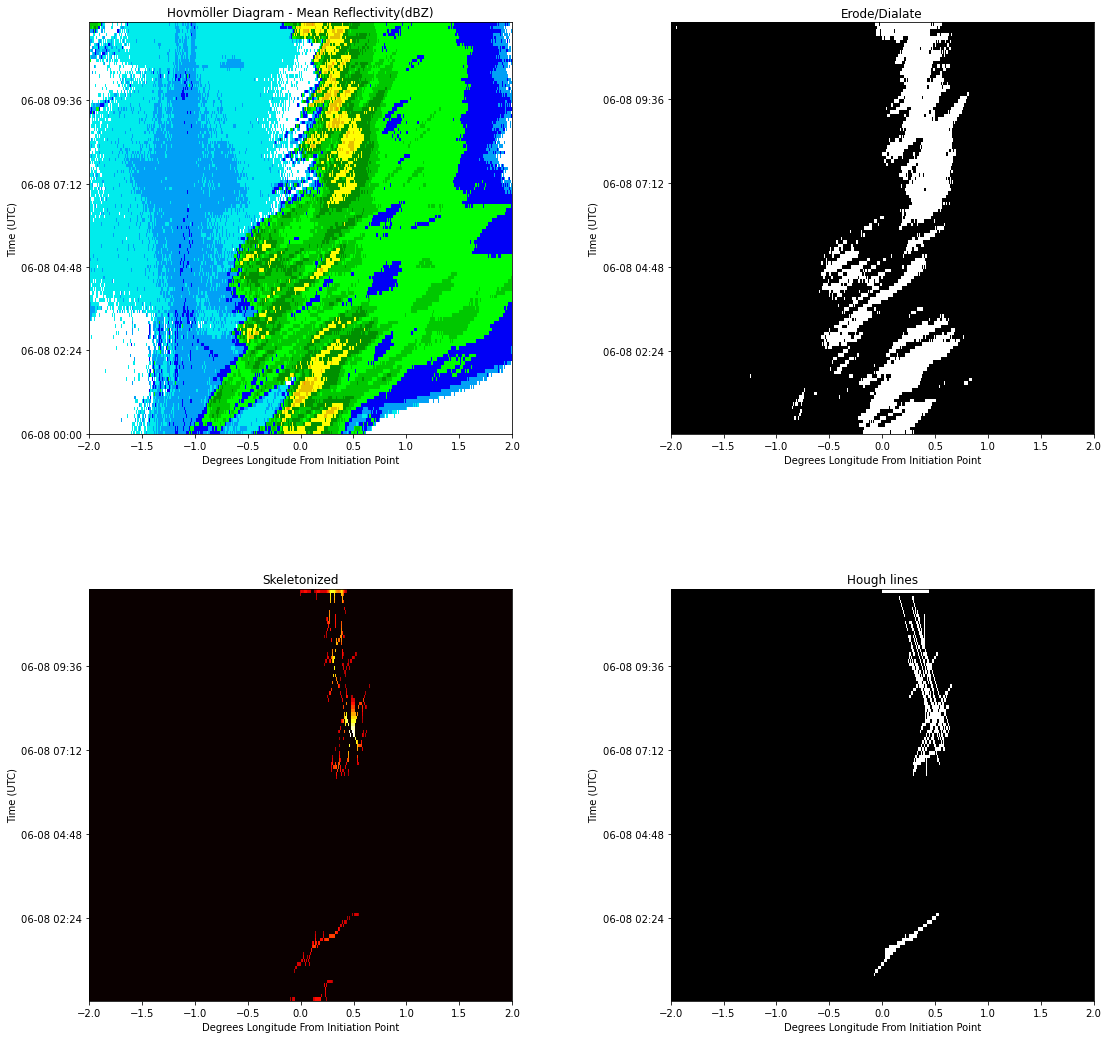

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18,18), gridspec_kw={'width_ratios':[10, 10], 
     'height_ratios': [10, 10], 'wspace': 0.375,
     'hspace': 0.375})

date_format = mpl_dates.DateFormatter('%m-%d %H:%M')
extent = [np.min(xlocs[:,0]) , np.max(xlocs[:,0]), np.min(dataDatetimes[0,:]) , np.max(dataDatetimes[0,:])]

norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5,5)

axes[0][0].pcolormesh( xlocs, dataDatetimes, data, norm=norm, cmap=cmap, shading='auto')
axes[0][0].set_xlabel("Degrees Longitude From Initiation Point")
axes[0][0].set_ylabel("Time (UTC)")
axes[0][0].set_title("Hovmöller Diagram - Mean Reflectivity(dBZ)")
axes[0][0].yaxis.set_major_formatter(date_format)
#axes[0][0].contour(xlocs, dataDatetimes, gaussian_filter(data, .5), 5, colors='k',interpolation='none')

axes[0][1].imshow(data_mask.T, cmap='gray', origin="lower", extent=extent, interpolation='none')
axes[0][1].set_xlabel("Degrees Longitude From Initiation Point")
axes[0][1].set_ylabel("Time (UTC)")
axes[0][1].set_title('Erode/Dialate')
axes[0][1].yaxis.set_major_formatter(date_format)
axes[0][1].set_aspect('auto')

axes[1][0].imshow(dist_on_skel.T, origin="lower", cmap='hot', extent=extent, interpolation='none')
axes[1][0].set_xlabel("Degrees Longitude From Initiation Point")
axes[1][0].set_ylabel("Time (UTC)")
axes[1][0].set_title('Skeletonized')
axes[1][0].yaxis.set_major_formatter(date_format)
axes[1][0].set_aspect('auto')

axes[1][1].imshow(cleaned, origin="lower", cmap='gray', extent=extent, interpolation='none')
#axes[1][1].imshow(data.T, cmap=cmap, norm=norm, origin="lower", extent=extent, interpolation='none')
#axes[1][1].add_collection(line_collect)
axes[1][1].set_xlabel("Degrees Longitude From Initiation Point")
axes[1][1].set_ylabel("Time (UTC)")
axes[1][1].set_title('Hough lines')
axes[1][1].yaxis.set_major_formatter(date_format)
axes[1][1].set_aspect('auto')
plt.show()

In [11]:
#The following is an attempt to quantify line segment parameters. 
#* This is a less desirable approach than classifying subsets of
#  the line segments via any number of classification schemes to
#  arrive at discrete groups

In [12]:
from math import sqrt
import skimage.filters as fil
from skimage.morphology import square
from skimage.morphology import disk
import seaborn as sns

In [13]:
#This cell is for testing how the code below reacts to lines with a negative slope. It adds fictitious data.

#lines.append(((57,277),(54,297)))
#lines.append(((67, 203),(49,276)))
#print(len(lines))


In [14]:
line_features = []
for line in lines:
    if line[0][0] == line[1][0]:
        if line[1][1] > line[0][1]:
            origin, end = line[0], line[1]
        else:
            origin, end = line[1], line[0]
    elif line[0][0] > line[1][0]:
        origin, end = line[1], line[0]
    elif line[0][0] < line[1][0]:
        origin, end = line[0], line[1]
    delt_x = (end[1] - origin[1])
    delt_y = (end[0] - origin[0])
    length = sqrt((delt_x)**2 + (delt_y)**2)
    try:
        slope = np.arctan(delt_y/delt_x)
    except:
        continue
    line_features.append([origin, delt_x, delt_y, length, slope])
print(len(line_features))

27


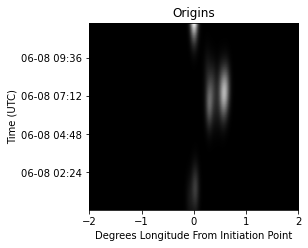

In [15]:
#Origin of Lines Map - This array is merely to detect the presence of the origins of Hough lines.

#First, the creation of the raw array.
origin_array = np.zeros((data.T.shape), dtype="float32")
for line in line_features:
    origin_array[line[0][0]][line[0][1]] = 1

origins_map = fil.gaussian(origin_array, sigma = 10)

gs  = gridspec.GridSpec(2,3, width_ratios=[5, 5, 10], 
                       height_ratios=[5,5],
                       top = 0.75,
                       bottom = 0.1,
                       wspace = 0.5,
                       hspace = 0.5)

fig = plt.figure(figsize=(20, 10), frameon=True)

negXLim, posXLim, negYLim, posYLim= -2.125,2.125,-2.125,2.125

ax0 = fig.add_subplot(gs[0,0])

ax0.imshow(origins_map, cmap='gray', origin="lower", extent=extent)
ax0.set_xlabel("Degrees Longitude From Initiation Point")
ax0.set_ylabel("Time (UTC)")
ax0.set_title('Origins')
ax0.yaxis.set_major_formatter(date_format)
ax0.set_aspect('auto')

In [16]:
#Magnitude (length) of Hough lines.

#Creation of raw array
mag_array = np.zeros(data.T.shape, dtype = "float32")
for line in line_features:
    mag_array[line[0][0]][line[0][1]] = line[3]

#Filter

mag_map = fil.gaussian(mag_array, sigma = 10)

ax1 = fig.add_subplot(gs[0,1])

ax1.imshow(mag_map, cmap='gray', origin="lower", extent=extent)
ax1.set_xlabel("Degrees Longitude From Initiation Point")
ax1.set_ylabel("Time (UTC)")
ax1.set_title('Local Magnitude')
ax1.yaxis.set_major_formatter(date_format)
ax1.set_aspect('auto')


In [17]:
#Delta_X Magnitude of Hough lines.

delt_x_array = np.zeros(data.T.shape, dtype = 'float32')
for line in line_features:
    delt_x_array[line[0][0]][line[0][1]] = line[1]

delt_x_map = fil.gaussian(delt_x_array, sigma=10)

ax2 = fig.add_subplot(gs[1,0])

ax2.imshow(delt_x_map, cmap='gray', origin="lower", extent=extent)
ax2.set_xlabel("Degrees Longitude From Initiation Point")
ax2.set_ylabel("Time (UTC)")
ax2.set_title('ΔX')
ax2.yaxis.set_major_formatter(date_format)
ax2.set_aspect('auto')


In [18]:
#Delta_Y Magnitude of Hough Lines

delt_y_array = np.zeros(data.T.shape, dtype = 'float32')
for line in line_features:
    delt_y_array[line[0][0]][line[0][1]] = line[2]

#print(delt_y_array.sum())

delt_y_map = fil.gaussian(delt_y_array, sigma = 10)

ax3 = fig.add_subplot(gs[1,1])

ax3.imshow(delt_y_map, cmap='gray', origin="lower", extent=extent)
ax3.set_xlabel("Degrees Longitude From Initiation Point")
ax3.set_ylabel("Time (UTC)")
ax3.set_title('ΔY')
ax3.yaxis.set_major_formatter(date_format)
ax3.set_aspect('auto')

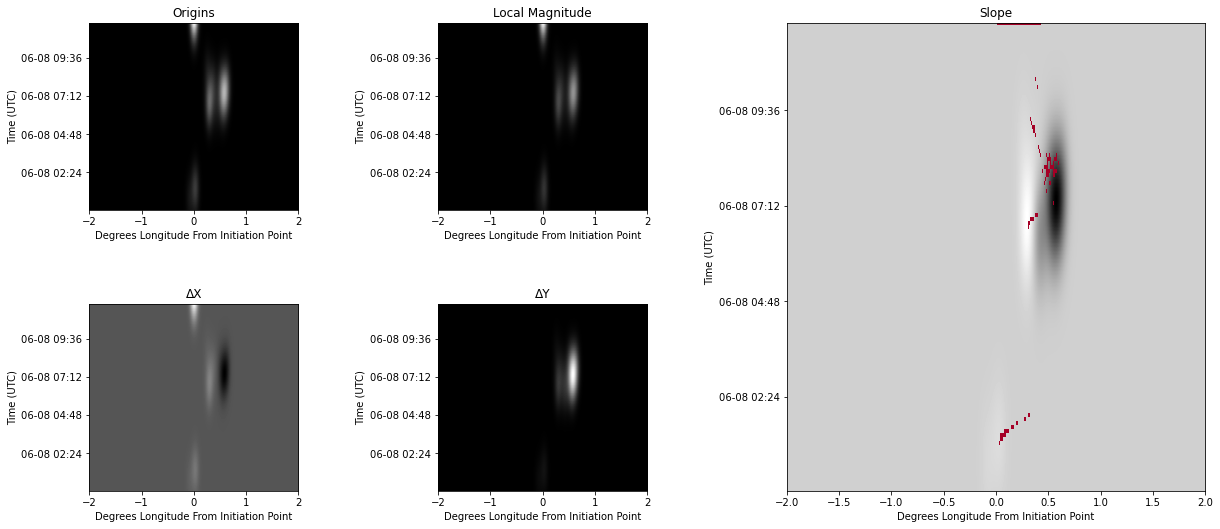

In [19]:
#Slope of Hough Lines
slope_array = np.zeros(data.T.shape, dtype = 'float32')

for line in line_features:
    slope_array[line[0][0]][line[0][1]] = line[4]

slope_map = fil.gaussian(slope_array, sigma=10)

cleaned_transp = np.where(cleaned==0, np.nan, cleaned)

ax4 = fig.add_subplot(gs[:,2])

ax4.imshow(slope_map, cmap='gray', origin="lower", extent=extent)
ax4.imshow(cleaned_transp, cmap='RdYlGn', origin="lower", extent=extent)

ax4.set_xlabel("Degrees Longitude From Initiation Point")
ax4.set_ylabel("Time (UTC)")
ax4.set_title('Slope')
ax4.yaxis.set_major_formatter(date_format)
ax4.set_aspect('auto')

fig